In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

import keras
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Introduction

Sepsis is a highly dangerous condition where the body’s response to infection or foreign sources cause further damage, from organ system damage, to septic shock, to death. According to the CDC, approximately 1.7 million people develop sepsis, while 270,000 die from it in the USA. Internationally, the WHO estimates that 30 million people suffer from sepsis, with a death rate of 6 million each year. In addition, the costs of diagnosing and treating sepsis in US hospitals alone costs up to $24 billion dollars. There is a very strong need for new methods to detect sepsis early and accurately. This is a significant need for hospitals and patients alike who are greatly affected by this disease. Creating a precise and accurate model that can predict early onset of sepsis would save lives, and hospitals from expending valuables resources. Predicting it too early consumes limited hospital resources, while predicting it too late makes improving sepsis outcomes incredibly challenging.

To create such a model, I will be using data made available through Physionet.org. Physionet is a platform that provides publically available datasets and offers yearly challenges to solving complex problems through using such data. It is very similar to Kaggle.com, however the primary differences are that Physionet focuses around clinical and medical data, and most importantly, the datasets are MESSY. They have not been preprocessed for typical statistical analysis and machine learning applications. Physionet’s 2019 Challenge is to use clinical data provided to assess early detection of Sepsis. I plan to participate in this challenge and will use such data to create my models.

## Data Cleansing and Visualization

The data consists of 5000 PSV files, each containing a patient’s clinical data starting at the patient’s admission to the ICU. Clinical data is collected hourly and is represented row-wise, with features including heart rate, temperature, white blood cell count, and many more. 

In [3]:
# Make a list of files for easy iterating
# There are 5000 patient files

patient_files = glob.glob('training/*.psv')
len(patient_files)

5000

The initial EDA approaches I took included: 
 - seeing how many of the patients tested positive
 - getting a visual distribution of the hour at which the patients ended up testing positive for sepsis.
 - observing where missing values were prevalent 

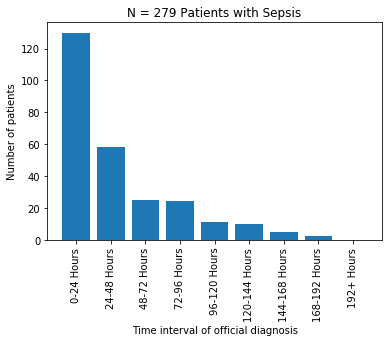

In [4]:
# Make the dictionary with first hour of diagnosis of sepsis as keys 
# and number of corresponding people as values 

# Also make a list of files of patients with and without Sepsis

first_hour, sepsis_files, no_sepsis_files = {}, [], []

first_hour['No Sepsis'] = 0
for file in patient_files:
    patient = pd.read_csv(file, sep='|')
    if 1 not in list(patient['SepsisLabel']):
        no_sepsis_files.append(file)
        first_hour['No Sepsis'] += 1
    else:
        sepsis_files.append(file)
        for idx, label in enumerate(patient['SepsisLabel']):
            if label == 1:
                hour = patient.loc[idx]['ICULOS'] 
                if hour not in first_hour:
                    first_hour[hour] = 0
                first_hour[hour] += 1
                break

# Create a new dictionary that further summarizes when the positive 
# patients get diagnosed within the first 24 hours, the next 24 hours, 
# and so on

new_first_hour = defaultdict(int)
for hour in list(first_hour.keys())[1:]:
    if hour <= 23:
        new_first_hour['0-24 Hours'] +=first_hour[hour]
        
    if hour >=24 and hour <= 47:
        new_first_hour['24-48 Hours'] +=first_hour[hour]
    
    if hour >=48 and hour <= 71:
        new_first_hour['48-72 Hours'] +=first_hour[hour]
    
    if hour >=72 and hour <= 95:
        new_first_hour['72-96 Hours'] +=first_hour[hour]
    
    if hour >=96 and hour <= 119:
        new_first_hour['96-120 Hours'] +=first_hour[hour]
    
    if hour >=120 and hour <= 143:
        new_first_hour['120-144 Hours'] +=first_hour[hour]
    
    if hour >=144 and hour <= 167:
        new_first_hour['144-168 Hours'] +=first_hour[hour]
    
    if hour >=168 and hour <= 191:
        new_first_hour['168-192 Hours'] +=first_hour[hour]
    
    if hour >=192:
        new_first_hour['200+ Hours'] +=first_hour[hour]

        
# Bar plot that shows how many hours after ICU admission do patients get official sepsis diagnosis

order = ['0-24 Hours', '24-48 Hours', '48-72 Hours', '72-96 Hours', '96-120 Hours', '96-120 Hours', 
         '120-144 Hours', '144-168 Hours', '168-192 Hours', '192+ Hours']
count = [new_first_hour[interval] for interval in order]

plt.bar(order,count)
plt.xticks(rotation=90)
plt.title('N = 279 Patients with Sepsis')
plt.xlabel('Time interval of official diagnosis')
plt.ylabel('Number of patients')
plt.show()

In [5]:
# Out of the 5000 patients, there are 279 cases where diagnosis of Sepsis was positive
len(sepsis_files)

279

In [6]:
# Example psv file of a negative patient (SepsisLabel column entirely consists of 0s)
negative_test = pd.read_csv(patient_files[2], sep='|')
negative_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,1,0
1,83.0,96.0,NaN,136.0,92.0,65.0,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,2,0
2,98.0,97.0,37.6,120.5,86.0,59.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,3,0
3,108.0,97.0,NaN,124.0,83.0,58.0,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,4,0
4,101.0,96.0,NaN,144.0,99.0,73.0,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,5,0
5,114.0,96.0,NaN,131.0,85.0,59.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,6,0
6,104.0,94.0,37.3,119.0,85.0,59.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,7,0
7,101.0,95.0,NaN,107.0,75.0,55.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,8,0
8,97.0,97.0,37.3,93.0,66.0,51.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,9,0
9,82.0,94.0,NaN,98.0,70.0,58.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59,1,0,1,-0.01,10,0


In [7]:
# Example psv file of a positive patient 
# Sepsis Label column converts from 0 to 1; this patient was diagnosed with Sepsis at their 6th hour in the ICU
positive_test = pd.read_csv(sepsis_files[20], sep='|')
positive_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,1,0
1,112.0,89.0,NaN,142.0,121.0,96.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,2,0
2,108.0,89.0,NaN,127.0,86.0,70.0,23.0,NaN,NaN,NaN,...,12.7,NaN,167.0,67,0,1,0,-0.12,3,0
3,106.0,89.5,NaN,107.5,89.5,73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,4,0
4,105.0,85.0,NaN,117.5,92.0,75.0,33.5,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,5,0
5,116.0,85.0,NaN,99.0,88.0,76.0,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,6,1
6,106.0,86.0,NaN,111.0,60.0,45.0,36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,7,1
7,110.0,83.0,36.8,119.0,96.0,79.0,38.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,8,1
8,117.0,93.5,36.7,108.5,87.0,65.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,9,1
9,126.0,83.0,37.2,127.5,78.0,67.5,19.0,35.0,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,10,1


At this point, we can observe that what makes each patient file unique is the size of the file, more specifically, the number of rows. From the example psv files and bar graph, we see that some patient files have as little as 15 rows while others may have up to 200. This simply shows that some patients have longer stays at ICUs than others.

Next we look at the available features. 

In [8]:
positive_test.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

The features here can be put into three main categories:

- Vital signs
    - HR:	Heart rate, (beats per minute)
    - O2Sat:	Pulse oximetry, (%)
    - Temp:	Temperature, (Deg C)
    - SBP:	Systolic BP, (mm Hg)
    - MAP:	Mean arterial pressure, (mm Hg)
    - DBP:	Diastolic BP, (mm Hg)
    - Resp:	Respiration rate, (breaths per minute)
    - EtCO2:	End tidal carbon dioxide, (mm Hg)
    
- Laboratory Values
    - BaseExcess:	Measure of excess bicarbonate, (mmol/L)
    - HCO3:	Bicarbonate, (mmol/L)
    - FiO2:	Fraction of inspired oxygen, (%)
    - pH:  potential Hydrogen
    - PaCO2:	Partial pressure of carbon dioxide from arterial blood, (mm Hg)
    - SaO2:	Oxygen saturation from arterial blood, (%)
    - AST:	Aspartate transaminase, (IU/L)
    - BUN:	Blood urea nitrogen, (mg/dL)
    - Alkalinephos:	Alkaline phosphatase, (IU/L)
    - Calcium:	(mg/dL)
    - Chloride:	(mmol/L)
    - Creatinine:	(mg/dL)
    - Bilirubin_direct: (mg/dL)
    - Glucose:	Serum glucose, (mg/dL)
    - Lactate:	Lactic acid, (mg/dL)
    - Magnesium:	(mmol/dL)
    - Phosphate:	(mg/dL)
    - Potassium:	(mmol/L)
    - Bilirubin_total:	Total bilirubin, (mg/dL)
    - TroponinI:	Troponin I, (ng/mL)
    - Hct:	Hematocrit, (%)
    - Hgb:	Hemoglobin, (g/dL)
    - PTT:	partial thromboplastin time, (seconds)
    - WBC:	Leukocyte count (count*10^3/µL)
    - Fibrinogen:	(mg/dL)
    - Platelets:	(count*10^3/µL)
    
- Demographics
    - Age:	Years (100 for patients 90 or above)
    - Gender:	Female (0) or Male (1)
    - Unit1:	Administrative identifier for ICU unit (MICU)
    - Unit2:	Administrative identifier for ICU unit (SICU)
    - HospAdmTime:	Hours between hospital admit and ICU admit
    - ICULOS:	ICU length-of-stay (hours since ICU admit)

Since the PSV files are divided, I want to concatenate them all into a single dataframe. This facilitates parsing through the different patients, specifically by adding an additional column (patientID), whose value would be unique to each individual patient. 

I handle the missing values in the Vital Sign columns by filling with the mean, because these features are more commonly collected hourly, meaning less frequent missing values, so such imputation methods like filling with the mean can suffice. 

The missing values in the Laboratory Value columns tend to be much more abundant, as in many cases, only 1 or 2 values are real. This is likely due to Lab values being collected much less frequently at the hospitals where the data came from. Therefore, the missing values from these columns are handled through forward and backward filling.

In [12]:
# Prelim attempt to make a usable dataframe for ML
# Handling the missing data

# Define the Vital Sign and Lab Value columns
VS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
LV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# Create a numerical ID unique associated with each patient
prelim = []

for patientID, file in enumerate(patient_files):
    patient = pd.read_csv(file, sep='|')
    patient['ID'] = patientID

    
    # Fill NaN values for VS features with mean
    for feature in VS_features:
        
        patient[feature].fillna((patient[feature].mean()), inplace = True)
        
        # Fill NaN values for LV features with ffill/bfill
        patient[LV_features] = patient[LV_features].fillna(method='ffill')
        patient[LV_features] = patient[LV_features].fillna(method='bfill')
    # Create a column with binary outcome of patient, each patient has either all 0s (no sepsis), or 1s, (gets sepsis)
    if 1 not in list(patient['SepsisLabel']):
        patient['Gets_Sepsis'] = 0
    else:
        patient['Gets_Sepsis'] = 1 
    prelim.append(patient)

prelim_df = pd.concat(prelim, ignore_index=True)

## Effect of Imputation

I would like to get a visualization of the effect from the imputation methods and see the resulting data distributions. I do this by comparing the imputed dataframe (prelim), with the original dataframe (prelim_nans)

In [13]:
prelim_nans = []

for patientID, file in enumerate(patient_files):
    patient = pd.read_csv(file, sep='|')
    patient['ID'] = patientID
    
    # Create a column with binary outcome of patient, each patient has either all 0s (no sepsis), or 1s, (gets sepsis)
    if 1 not in list(patient['SepsisLabel']):
        patient['Gets_Sepsis'] = 0
    else:
        patient['Gets_Sepsis'] = 1 
    
    prelim_nans.append(patient)


prelim_df_nans = pd.concat(prelim_nans, ignore_index=True)

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


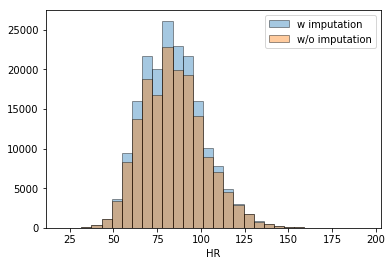

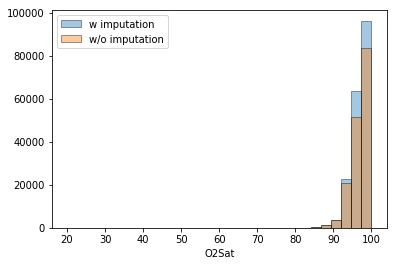

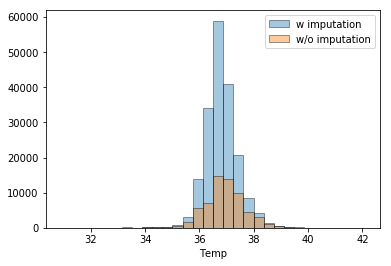

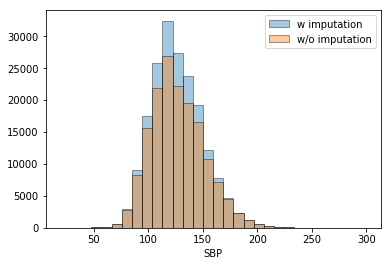

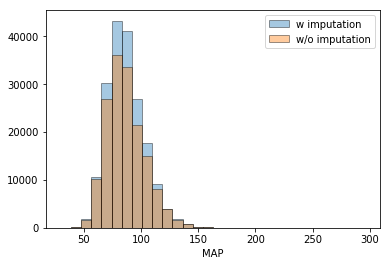

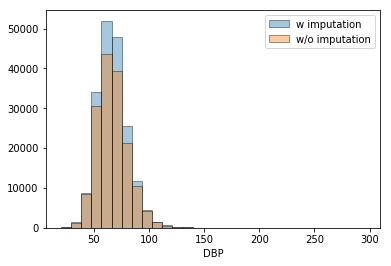

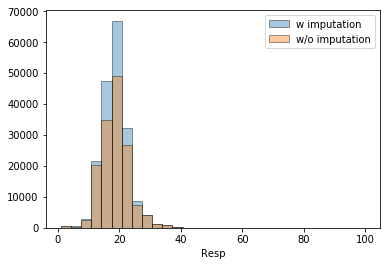

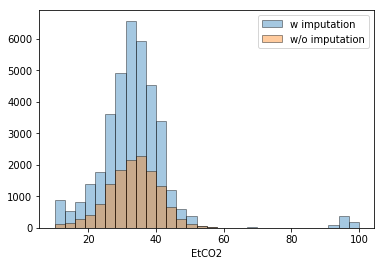

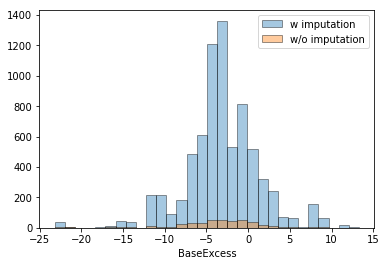

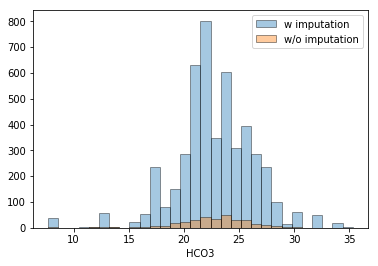

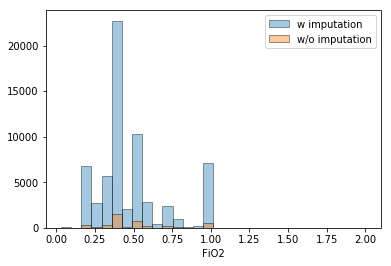

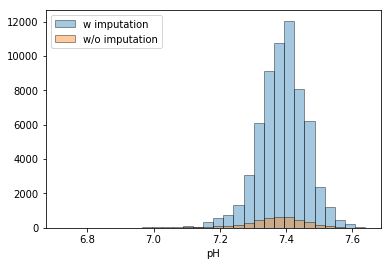

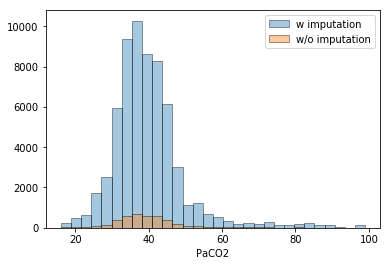

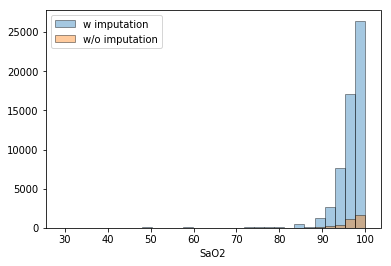

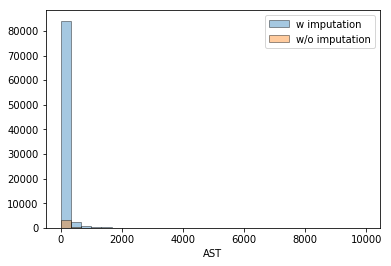

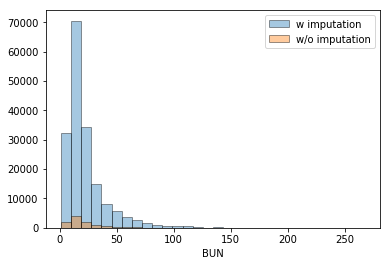

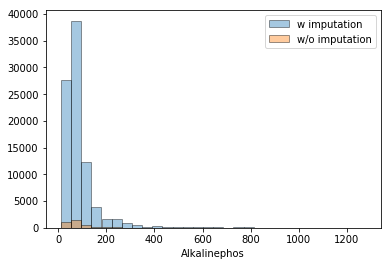

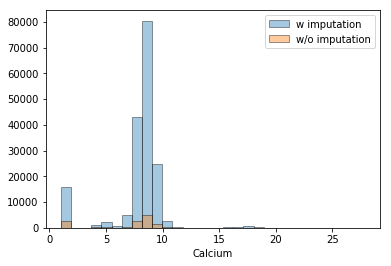

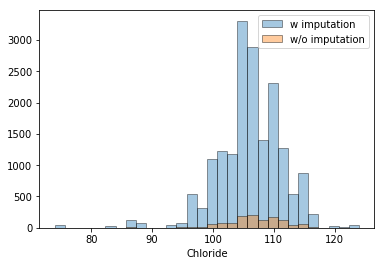

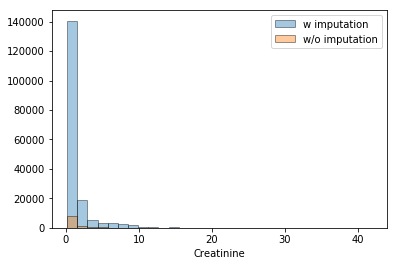

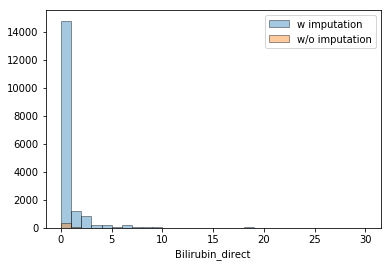

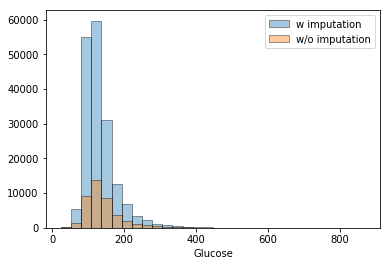

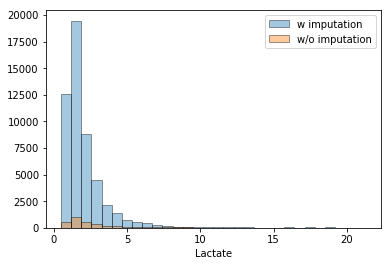

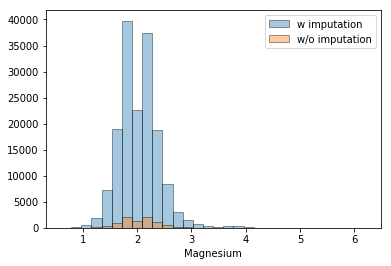

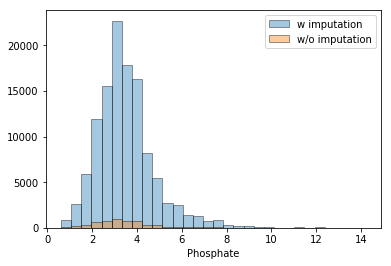

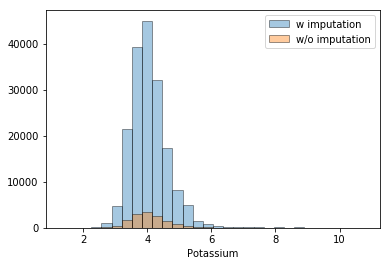

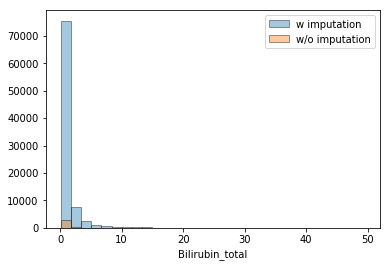

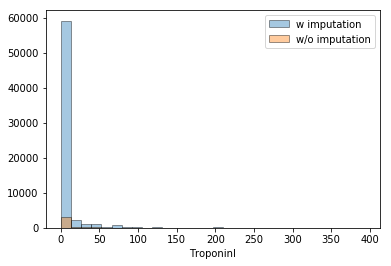

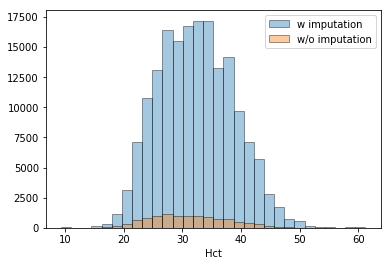

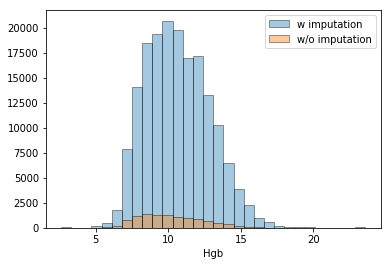

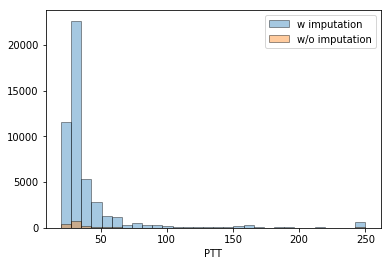

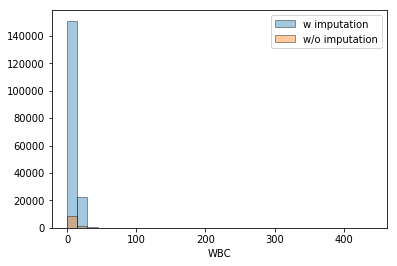

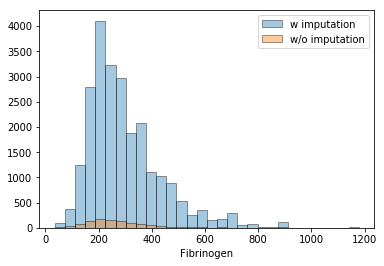

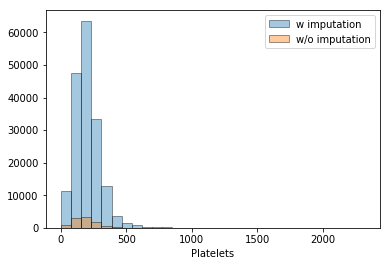

In [14]:
features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

for feature in features:
    plt.figure()
    sns.distplot(prelim_df[feature].dropna(), bins=30, kde=False, hist_kws=dict(edgecolor="k", linewidth=1), label='w imputation');
    sns.distplot(prelim_df_nans[feature].dropna(), bins=30, kde=False, hist_kws=dict(edgecolor="k", linewidth=1), label='w/o imputation');
    plt.legend()


Thus far, per individual patient, the only missing values left are those initially present in columns in its entirety. An example can be seen below, which also shows how easy it is now to extract different individual patient files using the 'ID' column.  

In [15]:
# The remaining NaNs are only present on entire columns
prelim_df[prelim_df['ID']==3]

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
109,87.324324,95.277778,36.61,161.138889,97.614286,65.402778,18.033333,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,1,0,3,0
110,86.000000,95.000000,36.61,176.000000,100.000000,68.000000,16.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,2,0,3,0
111,82.000000,97.000000,36.00,174.000000,96.000000,66.000000,14.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,3,0,3,0
112,88.000000,96.000000,36.61,166.000000,100.000000,70.000000,15.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,4,0,3,0
113,90.000000,95.000000,36.61,174.000000,102.000000,70.000000,16.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,5,0,3,0
114,94.000000,97.000000,36.61,176.000000,98.000000,66.000000,17.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,6,0,3,0
115,90.000000,97.000000,35.90,166.000000,90.000000,60.000000,18.033333,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,7,0,3,0
116,86.000000,96.000000,36.61,160.000000,94.000000,64.000000,12.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,8,0,3,0
117,86.000000,95.000000,36.61,154.000000,92.000000,62.000000,13.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,9,0,3,0
118,84.000000,97.000000,36.61,146.000000,88.000000,60.000000,20.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,10,0,3,0


From 5000 patients, we initially gather 188453 rows worth of hourly clinical data.

In [16]:
prelim_df.shape

(188453, 43)

## Machine Learning: Starting with the Vital Signs and Demographics

My approach is to generate many models with various amounts of features to determine optimal combinations of tuning that can allow for highly reliable prediction of sepsis, as well as to see the impact of the features can have on distinguishing the classes. To start, let's consider models fit to datasets only containing the vital sign and demographics columns. 

In [17]:
# Let's consider only the Vital Signs, as defined below: 

vital_sign_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
                      'Age', 'Gender', 'SepsisLabel', 'ID', 'Gets_Sepsis']
prelim_vitals = prelim_df[vital_sign_columns]

prelim_vitals.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,SepsisLabel,ID,Gets_Sepsis
count,188439.000000,188453.000000,188350.000000,188363.000000,188007.000000,188302.000000,187969.000000,37168.000000,188453.000000,188453.000000,188453.000000,188453.000000,188453.000000
mean,83.824787,97.069290,36.796500,126.518417,86.749469,66.625170,18.642654,33.347160,60.554085,0.541180,0.013919,2500.664908,0.082376
std,17.551059,2.871161,0.599552,23.710338,16.300998,13.833184,4.490248,11.359246,16.269188,0.498303,0.117153,1443.712885,0.274937
min,20.000000,20.000000,30.900000,20.000000,30.000000,20.000000,1.000000,10.000000,16.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,96.000000,36.442857,110.000000,75.096774,57.000000,16.000000,28.000000,50.000000,0.000000,0.000000,1242.000000,0.000000
50%,82.000000,97.500000,36.744444,124.000000,85.000000,65.000000,18.000000,33.000000,62.000000,1.000000,0.000000,2488.000000,0.000000
75%,95.000000,99.000000,37.110000,141.000000,96.000000,74.750000,21.000000,38.000000,72.000000,1.000000,0.000000,3753.000000,0.000000
max,194.000000,100.000000,42.100000,299.000000,296.000000,296.000000,100.000000,100.000000,101.000000,1.000000,1.000000,4999.000000,1.000000


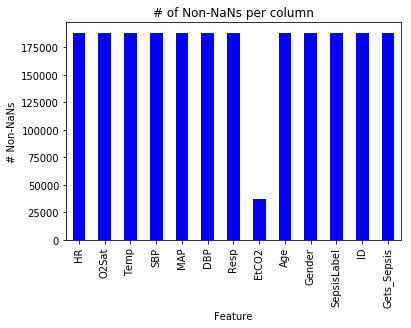

In [18]:
prelim_vitals.describe().loc['count'].plot(kind='bar', color = 'blue')
plt.xlabel('Feature')
plt.ylabel('# Non-NaNs')
plt.title('# of Non-NaNs per column');

In [19]:
for feature in list(prelim_vitals.columns):
    number_NaNs = prelim_vitals[prelim_vitals[feature].isnull()]['ID'].nunique()
    print("Number of patients with entirely missing columns from the {} feature: {}".format(feature, number_NaNs))

Number of patients with entirely missing columns from the HR feature: 1
Number of patients with entirely missing columns from the O2Sat feature: 0
Number of patients with entirely missing columns from the Temp feature: 10
Number of patients with entirely missing columns from the SBP feature: 2
Number of patients with entirely missing columns from the MAP feature: 17
Number of patients with entirely missing columns from the DBP feature: 4
Number of patients with entirely missing columns from the Resp feature: 16
Number of patients with entirely missing columns from the EtCO2 feature: 4216
Number of patients with entirely missing columns from the Age feature: 0
Number of patients with entirely missing columns from the Gender feature: 0
Number of patients with entirely missing columns from the SepsisLabel feature: 0
Number of patients with entirely missing columns from the ID feature: 0
Number of patients with entirely missing columns from the Gets_Sepsis feature: 0


There are missing values here and there for each feature, but as evidently shown from the from the analysis above, a LARGE number of patients, 4216 out of 5000 total, have completely missing values from the EtCO2 column (End tidal carbon dioxide, (mm Hg)), even after preliminary imputation techniques. The other columns, however, only have missing columns across a small number of patients.  

In order to preserve valuable rows and patients, it would make sense to remove the EtCO2 column, and then remove all patients who contain missing columns. I name this first dataset 'clean'.

In [20]:
# Because of the sheer amount of missing EtCO2 values, I decided to drop that feature
# as part of making my initial models

# Drop the EtCO2 column
prelim_vitals_noEtCO2 = prelim_vitals.drop('EtCO2',axis=1) 

# Drop patients with any missing values
clean = prelim_vitals_noEtCO2.dropna()

# Check how many patients we were able to preserve
clean.ID.nunique()

#We only lost 44 patients through this cleaning

4956

Now we can create a model for binary classification. Does a row belong to a patient who WILL or WILL NOT be diagnosed with Sepsis? 

To facilitate testing many models, the function 'make_model' was made that takes in the features (X), the predictor column (y), the model we would like to use, (model), and the parameter grid we would like to cover (param_grid), as this function incorporates GridSearchCV to apply cross-validation and hyperparameter tuning. In addition, the parameter, "scoring = 'roc_auc'", was specified so that the GridSearchCV object optimizes for the model with the best AUROC. As we saw in our initial EDA, only 279 out of 5000 patients get diagnosed with Sepsis, making this an imbalanced dataset. This makes the AUROC metric a very valuable metric to optimize as it will help distinguish the binary classes.   

When splitting the data to training and testing sets, it needs to be done such that rows from the same patient file do not get split into both sets, much like we would not want the same row to show up in both sets to prevent overfitting. We can use StratifiedKFold from sklearn to ensure that does not happen. StratifiedKFold splits datasets based on their indices, which is essentially what we want to do, but with their IDs instead of indices.  

In [21]:
def make_model(data, model, param_grid):
    '''Fits a model to a dataset, applying StratifiedKFold and GridSearchCV 
    for proper dataset splitting and hyperparameter tuning. Also generates an
    ROC Curve with AUROC specified'''
    
    # Define the X and y
    X_IDs = pd.Series(data['ID'].unique())
    y_outcomes = data[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']
    
    # Split the data
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_IDs, y_outcomes):
        X_train = data.loc[data['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        X_test =  data.loc[data['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        y_train = data.loc[data['ID'].isin(list(train_index))]['Gets_Sepsis']
        y_test = data.loc[data['ID'].isin(list(test_index))]['Gets_Sepsis']
    
    # Instantiate the GridSearchCV object: logreg_cv
    model_cv = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

    # Fit it to the training data
    model_cv.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model_cv.predict(X_test)
    
    # This will be useful for creating our ROC curves 
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();

    # Print the optimal parameters and best score
    print("Tuned Model Parameter: {}".format(model_cv.best_params_))
    print("Tuned AUROC {}".format(model_cv.best_score_))
    y_pred = model_cv.predict(X_test)
    print(classification_report(y_test, y_pred))

In [29]:
# Logistic Regression

logreg = LogisticRegression(solver='liblinear')
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
make_model(clean, logreg, param_grid)

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KeyboardInterrupt: 

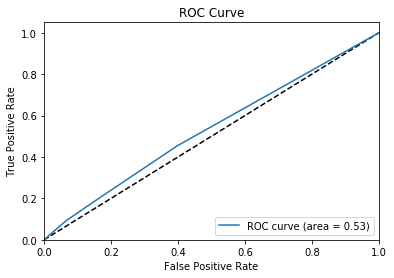

Tuned Model Parameter: {'n_neighbors': 10}
Tuned AUROC 0.5215157673522947
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     34099
           1       0.11      0.01      0.02      3218

    accuracy                           0.91     37317
   macro avg       0.51      0.50      0.48     37317
weighted avg       0.84      0.91      0.87     37317



In [30]:
# K-Nearest Neighbors

N = [1,2,3,4,5,6,7,8,9,10]
param_grid = {'n_neighbors': N}
knn = KNeighborsClassifier()

make_model(clean, knn, param_grid)

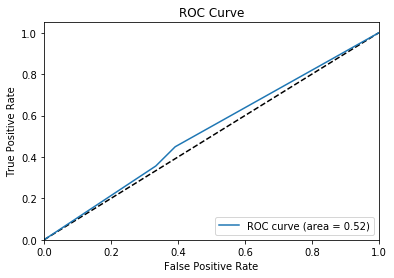

Tuned Model Parameter: {'max_depth': 3, 'min_samples_split': 10}
Tuned AUROC 0.6194447114435241
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     34099
           1       0.00      0.00      0.00      3218

    accuracy                           0.91     37317
   macro avg       0.46      0.50      0.48     37317
weighted avg       0.83      0.91      0.87     37317



In [31]:
# Desicion Tree

tree = DecisionTreeClassifier()
param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}

make_model(clean, tree,param_grid)

Using only the Vital Sign columns do not give us great models. Most of them output AUROCs near the value of 0.5. The features at this point do not sdistinguish the two outcomes (Sepsis vs No Sepsis)  

## Machine Learning: Adding the Laboratory Values

The next step is to include the Laboratory Value columns into the dataset and models. Before we get to that, Let's observe the number of real and missing values we are dealing with across all columns.  

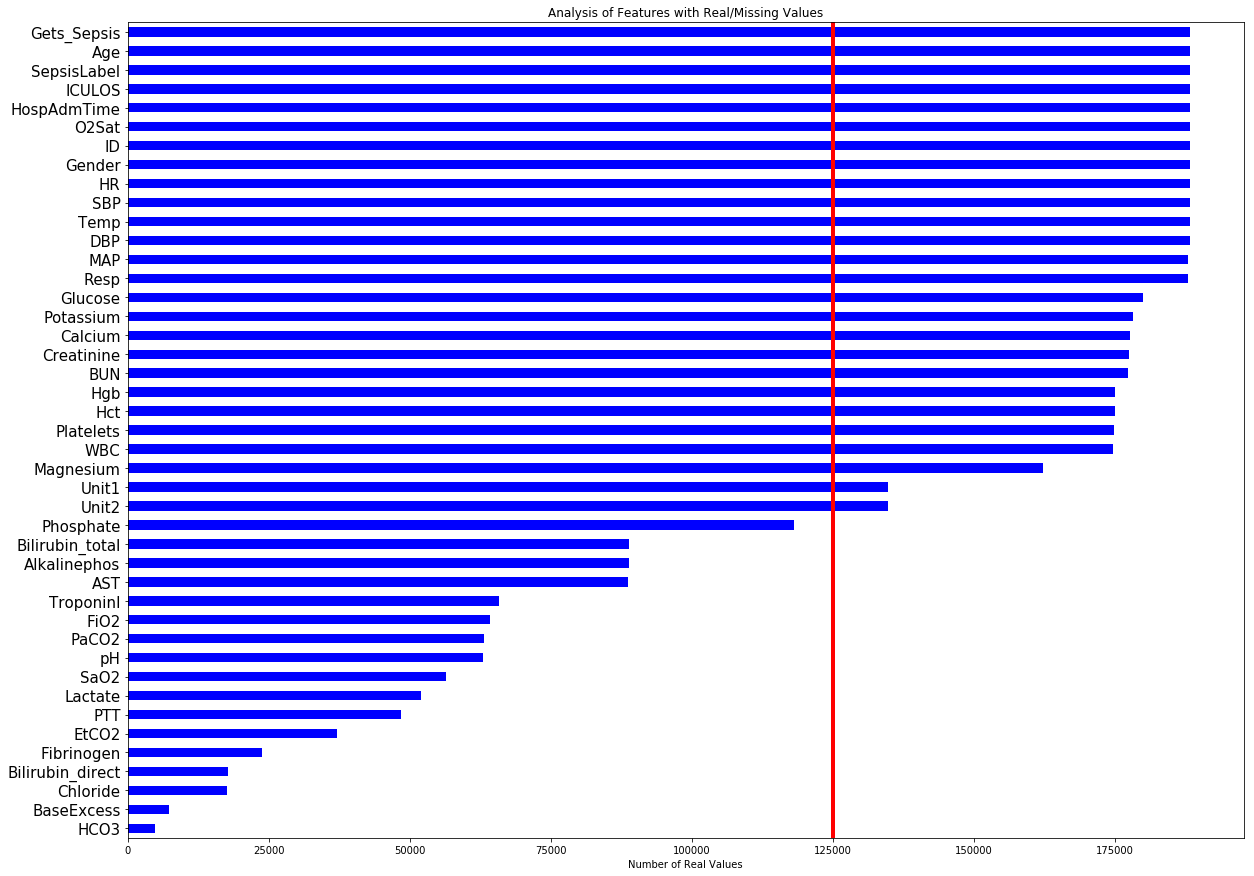

In [32]:
plt.figure(figsize=(20,15))
prelim_df.describe().loc['count'].sort_values().plot(kind = 'barh', color = 'b').tick_params(axis="y", labelsize=15);
plt.axvline(x=125000, linewidth=4, color = 'r');
plt.xlabel('Number of Real Values')
plt.title('Analysis of Features with Real/Missing Values');

This analysis is similar to the previous bar graph that revealed the high number of NaNs from the EtCO2 column, but more comprehensive. Again, this is after initial imputation techniques. While it would be ideal to be able to incorporate all available features, features with too many missing values can inhibit the number of patients that can be used in our models. This is why as part of including the Laboratory Value columns, the next dataset will still not include high-NaNs columns. I have selected the cut-off point to be at 150,000 rows (out of the 188,453 total). Features that do not have at least 150,000 rows worth of real values will not be included.   

In [33]:
# Highest # of NaNs: 

HighNaNs = ['Phosphate', 'Bilirubin_total', 'Alkalinephos', 'AST', 'TroponinI', 'FiO2', 'PaCO2',
            'pH', 'SaO2', 'Lactate', 'PTT', 'EtCO2', 'Fibrinogen', 'Bilirubin_direct', 'Chloride', 'BaseExcess',
            'HCO3']

prelim_df2 = prelim_df.drop(HighNaNs, axis = 1)
prelim_df2.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
count,188439.000000,188453.000000,188350.000000,188363.000000,188007.000000,188302.000000,187969.000000,177444.000000,177687.000000,177483.000000,...,174882.000000,188453.000000,188453.000000,134782.000000,134782.000000,188453.000000,188453.000000,188453.000000,188453.000000,188453.000000
mean,83.824787,97.069290,36.796500,126.518417,86.749469,66.625170,18.642654,22.080203,7.817188,1.606027,...,201.296723,60.554085,0.541180,0.488352,0.511648,-65.130534,25.587913,0.013919,2500.664908,0.082376
std,17.551059,2.871161,0.599552,23.710338,16.300998,13.833184,4.490248,18.839560,2.408893,2.084873,...,100.389161,16.269188,0.498303,0.499866,0.499866,235.957301,27.142730,0.117153,1443.712885,0.274937
min,20.000000,20.000000,30.900000,20.000000,30.000000,20.000000,1.000000,1.000000,1.000000,0.200000,...,2.000000,16.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000,0.000000,0.000000
25%,71.000000,96.000000,36.442857,110.000000,75.096774,57.000000,16.000000,11.000000,7.800000,0.730000,...,137.000000,50.000000,0.000000,0.000000,0.000000,-56.580000,10.000000,0.000000,1242.000000,0.000000
50%,82.000000,97.500000,36.744444,124.000000,85.000000,65.000000,18.000000,16.000000,8.400000,0.950000,...,189.000000,62.000000,1.000000,0.000000,1.000000,-8.800000,20.000000,0.000000,2488.000000,0.000000
75%,95.000000,99.000000,37.110000,141.000000,96.000000,74.750000,21.000000,26.000000,8.800000,1.400000,...,249.000000,72.000000,1.000000,1.000000,1.000000,-3.160000,34.000000,0.000000,3753.000000,0.000000
max,194.000000,100.000000,42.100000,299.000000,296.000000,296.000000,100.000000,268.000000,27.900000,41.900000,...,2322.000000,101.000000,1.000000,1.000000,1.000000,0.000000,336.000000,1.000000,4999.000000,1.000000


In [34]:
clean2 = prelim_df2.dropna()

# Check how many patients we were able to preserve? How many rows?
print(clean2.ID.nunique())
print(clean2.shape)

2948
(117518, 26)


With these rules established, we end up preserving 3962 out of 5000 patients, and thus 158212 rows out of 188,453 total. I then use the make_model function on the new dataset, clean2.

In [44]:
def make_model(data, model, param_grid):
    '''Fits a model to a dataset, applying StratifiedKFold and GridSearchCV 
    for proper dataset splitting and hyperparameter tuning. Also generates an
    ROC Curve with AUROC specified'''
    
    # Define the X and y
    X_IDs = pd.Series(data['ID'].unique())
    y_outcomes = data[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']
    
    # Split the data
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_IDs, y_outcomes):
        X_train = data.loc[data['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        X_test =  data.loc[data['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        y_train = data.loc[data['ID'].isin(list(train_index))]['Gets_Sepsis']
        y_test = data.loc[data['ID'].isin(list(test_index))]['Gets_Sepsis']
    
    # Instantiate the GridSearchCV object: logreg_cv
    model_cv = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

    # Fit it to the training data
    model_cv.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model_cv.predict(X_test)
    
    # This will be useful for creating our ROC curves 
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();

    # Print the optimal parameters and best score
    print("Tuned Model Parameter: {}".format(model_cv.best_params_))
    print("Tuned AUROC {}".format(model_cv.best_score_))
    y_pred = model_cv.predict(X_test)
    print(classification_report(y_test, y_pred))

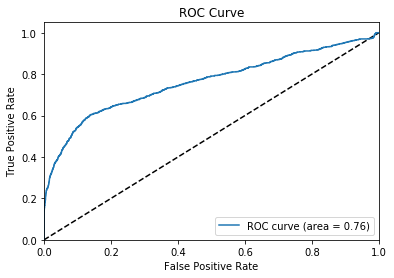

Tuned Model Parameter: {'C': 0.01, 'penalty': 'l2'}
Tuned AUROC 0.7419910596937985
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     13307
          1       0.83      0.17      0.29       999

avg / total       0.93      0.94      0.92     14306



In [354]:
# 125000
# Setup for Logreg model
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

make_model(clean2, logreg, param_grid)

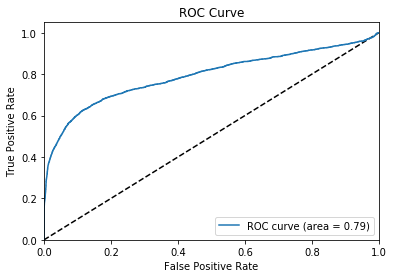

Tuned Model Parameter: {'C': 100.0, 'penalty': 'l1'}
Tuned AUROC 0.7523624924124687
             precision    recall  f1-score   support

          0       0.92      0.99      0.96     23009
          1       0.82      0.30      0.44      2753

avg / total       0.91      0.92      0.90     25762



In [138]:
# 150000
# Setup for Logreg model
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

make_model(clean2, logreg, param_grid)

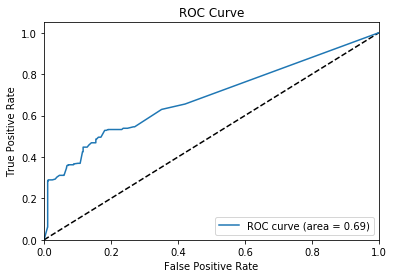

Tuned Model Parameter: {'max_depth': 19, 'min_samples_split': 490}
Tuned AUROC 0.7338332378909456
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     13307
           1       0.47      0.29      0.36       999

    accuracy                           0.93     14306
   macro avg       0.71      0.63      0.66     14306
weighted avg       0.91      0.93      0.92     14306



In [45]:
# Instantiate the DT classifier: tree
tree = DecisionTreeClassifier()

# Set up param grid
param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}


make_model(clean2,tree,param_grid)

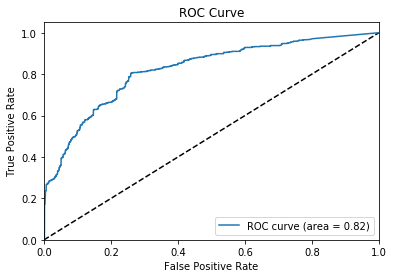

Tuned Model Parameter: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 330}
Tuned AUROC 0.7787258305820507
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13307
           1       0.74      0.24      0.36       999

    accuracy                           0.94     14306
   macro avg       0.85      0.62      0.67     14306
weighted avg       0.93      0.94      0.93     14306



In [49]:
# Instantiate the RF classifier: forest
forest = RandomForestClassifier(n_estimators = 10)

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

make_model(clean2, forest, param_grid)

The addition of Lab Values shows a tremendous improvement on the models' abilites to distinguish and predict these different classes, as the AUROC values increases from about 0.5 to 0.8 on average. This shows that the Lab Value features are very important predictors for predicting sepsis outcomes.  

## Machine Learning: Adding the Clinical latent Variables 

The next step I would like to implement is the addition of clinical latent variables. From the features we have, we can include additional clinically relevant features that can help discriminate between the two classes. Here, we will include Shock Index, which is the Heart Rate divided by the Systolic Blood Pressure, and the Oxygen Delivery Index, which is the multiplication of the Heart Rate, the pulse pressure (SBP-DBP), Oxygen Saturation, and Hemoglobin. The inspiration and motivation of this feature engineering comes from research and papers that discuss clinical data modeling to predict the outcome of cardiac arrest.

In [38]:
clean3 = clean2.copy()

clean3['ShockIndex'] = clean3['HR']/clean3['SBP']
clean3['O2DeliveryIndex'] = clean3['HR']*(clean3['SBP']-clean3['DBP'])*clean3['Hgb']*clean3['O2Sat']
clean3.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,1,0,0,0,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,2,0,0,0,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,3,0,0,0,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,4,0,0,0,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,5,0,0,0,0.858491,3.354952e+06


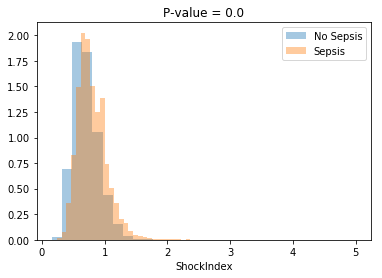

In [39]:
plt.figure()
shock_no_sepsis = clean3[clean3['Gets_Sepsis']==0]['ShockIndex']
shock_yes_sepsis = clean3[clean3['Gets_Sepsis']==1]['ShockIndex']
shock_t_results = sp.stats.ttest_ind(shock_no_sepsis, shock_yes_sepsis)
shock_p_value = list(shock_t_results)[1]

sns.distplot(shock_no_sepsis, bins=30, kde=False, norm_hist=True, label='No Sepsis');
sns.distplot(shock_yes_sepsis, bins=30, kde=False, norm_hist=True, label='Sepsis');
plt.title('P-value = {}'.format(shock_p_value))
plt.legend();

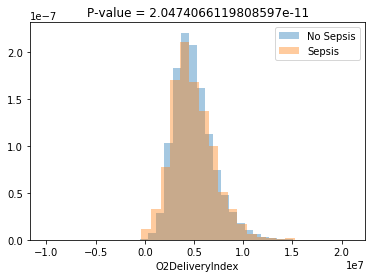

In [40]:
plt.figure()
O2_no_sepsis = clean3[clean3['Gets_Sepsis']==0]['O2DeliveryIndex']
O2_yes_sepsis = clean3[clean3['Gets_Sepsis']==1]['O2DeliveryIndex']
O2_t_results = sp.stats.ttest_ind(O2_no_sepsis, O2_yes_sepsis)
O2_p_value = list(O2_t_results)[1]

sns.distplot(O2_no_sepsis, bins=30, kde=False, norm_hist=True, label='No Sepsis');
sns.distplot(O2_yes_sepsis, bins=30, kde=False, norm_hist=True, label='Sepsis');
plt.title('P-value = {}'.format(O2_p_value))
plt.legend();

Based on these distribution plots on resulting p-values, we gather that the mean Shock Index is in fact statistically different between the population diagnosed with Sepsis and the population without (p-value ~ 0). Meanwhile, the mean O2 Delivery Index shows no statistically significant difference between these two populations (p-value ~ 0.39). Regardless, they will both be added for our next round of models.

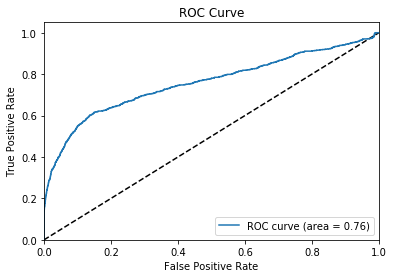

Tuned Model Parameter: {'C': 1000000.0, 'penalty': 'l1'}
Tuned AUROC 0.7403151974903349
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     13307
          1       0.85      0.17      0.28       999

avg / total       0.93      0.94      0.92     14306



In [359]:
# Setup for Logreg model
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2'], 'solver':'liblinear'}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

make_model(clean3, logreg, param_grid)

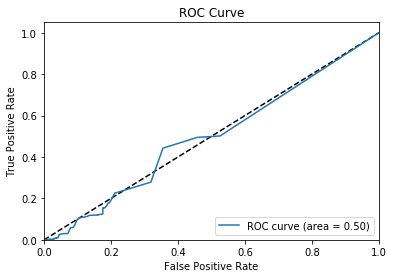

Tuned Model Parameter: {'max_depth': 19, 'min_samples_split': 430}
Tuned AUROC 0.5834419034381889
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     13307
           1       0.02      0.01      0.01       999

    accuracy                           0.90     14306
   macro avg       0.47      0.49      0.48     14306
weighted avg       0.86      0.90      0.88     14306



In [41]:
# Instantiate the DT classifier: tree
tree = DecisionTreeClassifier()

# Set up param grid
param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}


make_model(clean3, tree, param_grid)

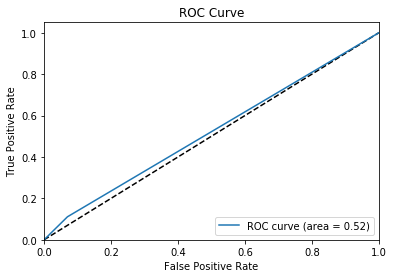

Tuned Model Parameter: {'n_neighbors': 1}
Tuned AUROC 0.5034492183370218
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13307
           1       0.11      0.11      0.11       999

    accuracy                           0.87     14306
   macro avg       0.52      0.52      0.52     14306
weighted avg       0.88      0.87      0.87     14306



In [42]:
# K-Nearest Neighbors

N = [1,2,3,4,5,6,7,8,9,10]
param_grid = {'n_neighbors': N}
knn = KNeighborsClassifier()

make_model(clean3, knn, param_grid)

In [ ]:
# Instantiate the RF classifier: forest
forest = RandomForestClassifier()

param_grid = {"n_estimators":[10,100],
              "max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

make_model(clean3, forest, param_grid)

## Machine Learning: Adding the Time-Series Trends

With this being a unique time series problem, the next appropriate round of features to include would be trend features, in other words, features that can capture how the features change over time and capture information on previous rows. Here I implement two techniques: firstly, for the vital sign columns, specified in the list 'time_features', I add an additional lag column, which shifts the original column down one row. Secondly, for each of the same columns mentioned previously, I add another additional rolling mean column, which is the mean of the three previous values.   

In [ ]:
clean4 = clean3.copy()
clean4.head()

In [ ]:
# Make a new dataframe with columns that take into account the time-series nature of the original dataset

time_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']

for column in time_features:
    clean4[str(column)+'_lag'] = clean2[column].shift()
    clean4[str(column)+'_rolling'] = clean2[column].rolling(3).mean()
clean4.head()

In [ ]:
clean4.dropna(inplace=True)
clean4.reset_index(inplace=True)
clean4.head()

In [ ]:
clean4.shape

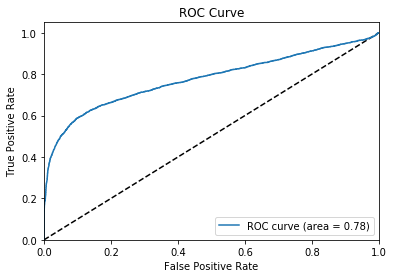

Tuned Model Parameter: {'C': 100.0, 'penalty': 'l1'}
Tuned AUROC 0.7504809651891615
             precision    recall  f1-score   support

          0       0.92      0.99      0.95     23009
          1       0.79      0.29      0.43      2753

avg / total       0.91      0.92      0.90     25762



In [164]:
# Setup for Logreg model
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

make_model(clean4,logreg,param_grid)

In [ ]:
# Instantiate the DT classifier: tree
tree = DecisionTreeClassifier()

# Set up param grid
param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}


make_model(clean4,tree,param_grid)

## Machine Learning: Deep Learning

At this point, I want to employ modeling techniques that take more in account the possible interactions between the different features, which can be very valuable due to the clinical nature of the data. Because of this, I went ahead and developed a deep learning model using Keras.

The model contains two hidden layers, both containing 50 nodes and using the relu function. The output layer outputs a single node and uses the sigmoid function. The adam optimizer was implemented and uses the binary cross-entropy for the loss function, which is standard for binary classification problems. 

In [291]:
# Prepare the data for deep learning
predictors = clean3.drop('Gets_Sepsis', axis = 1).values
target = clean3['Gets_Sepsis']


In [293]:
# Save the number of columns in predictors: n_cols
n_cols = predictors.shape[1]

# Set up the model: model
DL_model = Sequential()

# Add the first layer
DL_model.add(Dense(50, activation='relu', input_shape=(n_cols,)))

# Add the second layer
DL_model.add(Dense(50, activation='relu'))

# Add the output layer
DL_model.add(Dense(1, activation='sigmoid'))

#Compiling the neural network
DL_model.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
DL_model.fit(predictors, target, validation_split=0.3, epochs = 20, callbacks = [early_stopping_monitor])

Instructions for updating:
Use tf.cast instead.
Train on 110748 samples, validate on 47464 samples
Epoch 1/20
110748/110748 [==============================] - 6s 56us/step - loss: 1.4561 - acc: 0.9097 - val_loss: 1.5689 - val_acc: 0.9027
Epoch 2/20
110748/110748 [==============================] - 5s 48us/step - loss: 1.4561 - acc: 0.9097 - val_loss: 1.5689 - val_acc: 0.9027
Epoch 3/20
110748/110748 [==============================] - 5s 48us/step - loss: 1.4561 - acc: 0.9097 - val_loss: 1.5689 - val_acc: 0.9027


In [ ]:
DL_

In [ ]:
# Save the model

DL_model.

In [41]:
# Make a new function, make_scaled_model, that implements a StandardScaler step to the dataset

def make_scaled_model(X, y, model, param_grid):
    
    steps = [('scaler', StandardScaler()),
        ('model', model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)
    
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_IDs, y_outcomes):
        X_train3 = clean2.loc[clean2['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        X_test3 =  clean2.loc[clean2['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        y_train3 = clean2.loc[clean2['ID'].isin(list(train_index))]['Gets_Sepsis']
        y_test3 = clean2.loc[clean2['ID'].isin(list(test_index))]['Gets_Sepsis']
    
    # Instantiate the GridSearchCV object
    model_scaled = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

    # Fit the pipeline to the training set
    model_scaled.fit(X_train3, y_train3)

    # Print the optimal parameters and best score
    print("Tuned Scaled Model Parameter: {}".format(model_scaled.best_params_))
    print("Tuned Scaled Model ROC_AUC: {}".format(model_scaled.best_score_))
    y_pred = model_scaled.predict(X_test3)
    print(classification_report(y_test3, y_pred)) 

In [327]:
X_IDs = pd.Series(clean3['ID'].unique())
y_outcomes = clean3[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_IDs, y_outcomes):
    X_train = clean3.loc[clean3['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    X_test =  clean3.loc[clean3['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    y_train = clean3.loc[clean3['ID'].isin(list(train_index))]['Gets_Sepsis']
    y_test = clean3.loc[clean3['ID'].isin(list(test_index))]['Gets_Sepsis']
    

In [332]:
clean3.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,125.0,54,1,-5.76,1,0,0,0,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,-5.76,2,0,0,0,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,125.0,54,1,-5.76,3,0,0,0,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,-5.76,4,0,0,0,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,-5.76,5,0,0,0,0.858491,3.354952e+06


In [333]:
X_train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,31.1,9.8,6.1,125.0,54,1,-5.76,1,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,31.1,9.8,6.1,125.0,54,1,-5.76,2,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,31.1,9.8,6.1,125.0,54,1,-5.76,3,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,31.1,9.8,6.1,125.0,54,1,-5.76,4,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,31.1,9.8,6.1,125.0,54,1,-5.76,5,0.858491,3.354952e+06


In [342]:
#Tuned Model Parameter: {'max_depth': 9, 'min_samples_split': 490}
best_model = DecisionTreeClassifier(max_depth=9, min_impurity_split=490)
best_model.fit(X_train, y_train)

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  sample_weight = expanded_class_weight


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=490,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [320]:
# This is the one that works......??????????
best_model = RandomForestClassifier(bootstrap=True, criterion='gini', 
                                    max_depth=None, max_features=10, min_samples_split=310)
best_model.fit(X_train3, y_train3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=310,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [340]:
# Going from timepoint predictions to patient predictions (FOCUS ON THIS ONE)

def predict_patient(model, patients):
    '''Takes in an entire patient file, predicts risk of Sepsis based on 
    timepoint, and infers whether the patient is at risk of getting Sepsis, based on
    multiple thresholds of positive timestamps'''
    

    # Establish the potential thresholds to iterate through
    #pct_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    pct_threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
    
    # Initiate lists for data viz
    accuracy_score_list = [] 
    precision_list = []
    recall_list = []
    f1_score_list = [] 
    
    for pct in pct_threshold: 
        # Initiate the parameter variables
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        accuracy = 0

        for patient in patients: 
            if 1 not in list(patient['SepsisLabel']):
                gets_sepsis = False
            else:
                gets_sepsis = True
            
            # Generate predictions per timepoint (rows) 
            X = patient.drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
            outcomes = model.predict(X)
            if sum(outcomes)/len(outcomes) >= pct:
                outcome = True
                if outcome == gets_sepsis:
                    tp += 1
                    accuracy += 1
                else:
                    fp += 1
            else:
                outcome = False
                if outcome == gets_sepsis:
                    tn += 1
                    accuracy += 1
                else:
                    fn += 1
                    
        accuracy_score = accuracy/len(patients)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = 2*((precision*recall)/(precision+recall))
        
        accuracy_score_list.append(accuracy_score) 
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        
        print('Accuracy with positive threshold set at {}: {})'.format(pct, accuracy_score))
        print('Precision with positive threshold set at {}: {})'.format(pct, precision))
        print('Recall with positive threshold set at {}: {})'.format(pct, recall))
        print('F1-Score with positive threshold set at {}: {})'.format(pct, f1_score))
        print(" ")
    
    # set width of bar
    barWidth = 0.15
    
    # Make the grouped bar plot 
    # Set position of bar on X axis
    r1 = np.arange(len(accuracy_score_list))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    
    # Make the plot
    plt.figure(figsize=(20,10))
    plt.bar(r1, accuracy_score_list, color='blue', width=barWidth, edgecolor='white', label='Accuracy')
    plt.bar(r2, precision_list, color='orange', width=barWidth, edgecolor='white', label='Precision')
    plt.bar(r3, recall_list, color='green', width=barWidth, edgecolor='white', label='Recall')
    plt.bar(r4, f1_score_list, color='red', width=barWidth, edgecolor='white', label='F1')
 
    # Add xticks on the middle of the group bars
    plt.xlabel('% threshold', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(accuracy_score_list))], pct_threshold)
 
    # Create legend & Show graphic
    plt.legend()
    plt.show()


Accuracy with positive threshold set at 0.01: 0.9572591587516961)
Precision with positive threshold set at 0.01: 0.5952380952380952)
Recall with positive threshold set at 0.01: 0.5)
F1-Score with positive threshold set at 0.01: 0.5434782608695652)
 
Accuracy with positive threshold set at 0.02: 0.9592944369063772)
Precision with positive threshold set at 0.02: 0.6271186440677966)
Recall with positive threshold set at 0.02: 0.49333333333333335)
F1-Score with positive threshold set at 0.02: 0.5522388059701493)
 
Accuracy with positive threshold set at 0.03: 0.9606512890094979)
Precision with positive threshold set at 0.03: 0.6574074074074074)
Recall with positive threshold set at 0.03: 0.47333333333333333)
F1-Score with positive threshold set at 0.03: 0.5503875968992248)
 
Accuracy with positive threshold set at 0.04: 0.9613297150610584)
Precision with positive threshold set at 0.04: 0.6730769230769231)
Recall with positive threshold set at 0.04: 0.4666666666666667)
F1-Score with positiv

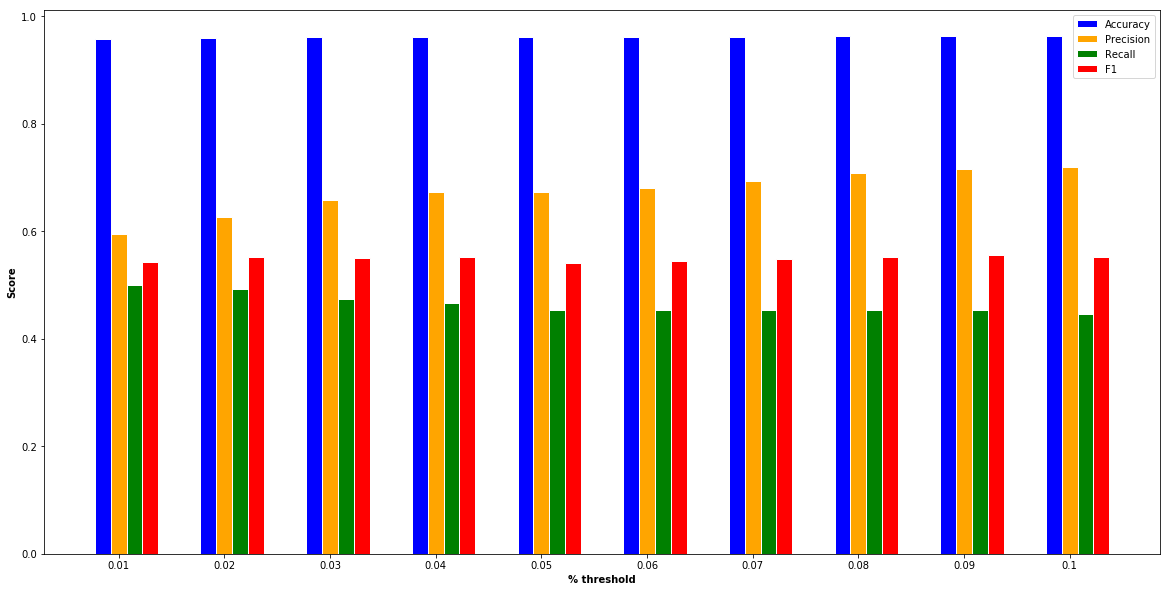

In [322]:
predict_patient(best_model, patients)

In [80]:
def make_roc_curve(model, patients):
    '''Takes in an entire patient file, predicts risk of Sepsis based on 
    timepoint, and generates a sepsis prediction score to create an ROC curve
    and obtain the AUROC'''
    
    sepsis_status = []
    df_roc = pd.DataFrame()
    
    
    # Make the sepsis_status column
    for patient in patients: 
        if 1 not in list(patient['SepsisLabel']):
            gets_sepsis = 0
        else:
            gets_sepsis = 1
        sepsis_status.append(gets_sepsis)
        
    df_roc['Sepsis_status'] = sepsis_status
    
    # Make the sepsis score column   
    sepsis_score = []
    for patient in patients:
        # Generate predictions per timepoint (rows) 
        X = patient.drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        outcomes = model.predict(X)
        ratio = sum(outcomes)/len(outcomes)            
        sepsis_score.append(ratio)
        
    df_roc['Sepsis_score'] = sepsis_score
    fpr, tpr, _ = roc_curve(df_roc['Sepsis_status'], df_roc['Sepsis_score'])
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
            

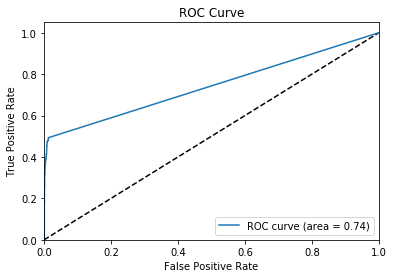

In [81]:
make_roc_curve(best_model, patients)

In [310]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=310,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# NOTES 


# https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-8-40
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6299613/pdf/13054_2018_Article_2279.pdf

# Standardize Candidate Feature Formatting
# There are fixed intervals (vital signs like HR and temp), and non-standard intervals (platelets and WBC)

# Vital signs (columns 1-8) -> Time Series features 
# Laboratory values (columns 9-34) -> Multivariate features 
# Personal info (columns 35-40) -> Demographic features

# Time Series
# Fill NaN values with mean values 


# Notes:
# Deal with the imbalance
# create a was_analyzed features
# a lag

# Notes: 
# Systolic should always be greater than diastolic by definition. 

# 'HR'
# 'O2Sat'
# 'Temp',
# 'SBP',
# 'MAP',
# 'DBP',
# 'Resp',
# 'EtCO2',

# Multivariate features 
# Literature says to use the most recent multivariate features before onset of sepsis, but there are some values where
# I may want to forward/backward fill

 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',


# Demographic features

# 'Age' -> One value
# 'Gender', -> One value 
# 'Unit1', -> I say ignore
# 'Unit2', -> I say ignore
# 'HospAdmTime', -> I say ignore 
# 'ICULOS', -> Must be useful somewhere


# Clinical latent features (can be treated like time series)

# Shock index = HR/SBP
# O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

# Trend features of time series
# Max, min, mean, mode, median, slope, intercept

# Predictor variable

# SepsisLabel